In [2]:
import pandas as pd
import numpy as np
import stan
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [3]:
import os
os.environ['CMDSTAN'] = '/Users/indiaermacora/.cmdstan/cmdstan-2.31.0'

In [4]:
from cmdstanpy import CmdStanModel, set_cmdstan_path, cmdstan_path
import arviz as az
import os

/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
cmdstan_path()

'/Users/indiaermacora/.cmdstan/cmdstan-2.31.0'

In [6]:
nugget = pd.read_csv('stan/nugget_to_python.csv', sep = ";")
dati_covariates = pd.read_csv('stan/covariates.csv', sep = ";")
dat_complete_log = pd.read_csv('stan/dat_complete_log_to_python.csv', sep = ";")
ind_pres=pd.read_csv('stan/ind_pres_to_python.csv', sep = ";")
ind_miss=pd.read_csv('stan/ind_miss_to_python.csv', sep = ";")
lat_long=pd.read_csv('stan/lat_long_2_to_python.csv', sep = ";")
dat_2017_log=pd.read_csv('stan/log_dati_2017.csv', sep = ";")

In [7]:
dat_complete_log.mean()[0]

2.7607208499144247

In [8]:
matrix_dati_covariates=np.matrix(dati_covariates)
dat_2017_log_matrix= np.matrix(dat_2017_log, dtype=float)
dat_2017_log_matrix_centered= dat_2017_log_matrix-dat_complete_log.mean()[0]

quota= np.array (matrix_dati_covariates[0,:], dtype=int)
quota_norm = ((quota-quota.mean())/quota.std())

area_dummies = pd.get_dummies(dati_covariates.iloc[1, :])
zona_dummies = pd.get_dummies(dati_covariates.iloc[2, :])

all_cov = np.matrix(pd.concat([area_dummies.Urbano],axis=1),dtype=int)
all_cov = np.concatenate((np.transpose(quota_norm),all_cov),axis=1)

ind_miss = np.array(ind_miss)
ind_pres = np.array(ind_pres)
dat_complete_log= np.array(dat_complete_log, dtype=float)
dat_complete_log_centered= dat_complete_log- dat_complete_log.mean() 

nugget_mat = np.matrix(nugget, dtype=float)
coord = np.matrix( pd.concat([lat_long.Lat, lat_long.Long], axis=1) )

month=np.repeat(np.array([1,2,3,4,5,6,7,8,9,10,11,12]), [31,28,31,30,31,30,31,31,30,31,30,31])


In [9]:
all_cov.shape

(62, 2)

In [10]:
import cmdstanpy
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.31.0
Install directory: /Users/indiaermacora/.cmdstan
CmdStan version 2.31.0 already installed


True

In [60]:
#all stations

arima_model = """

data {
  int<lower=0> num_giorni;
  int<lower=0> num_stazioni;
  
  matrix[num_stazioni, 2] covariates;
  
  int Ncomp; // Number of non-missing values
  int  Nmiss; // Number of missing values
  vector [Ncomp] dat_complete;
  int ind_pres[Ncomp, 2];
  int ind_miss[Nmiss, 2];

  matrix[num_stazioni,num_stazioni] dist_w;  //distance matrix
  real phi;
  matrix[6,num_stazioni] y_2017; 
  vector[num_giorni] days;
  int mese[num_giorni];

  int C;

}


parameters {
  vector[num_stazioni] phi1;
  vector<lower=0>[12] sigma;
  
  real beta_0;
  vector[2] beta_cov;
  
  vector [Nmiss] dat_miss;

  real<lower=0> a;
  vector[num_stazioni] w;
  real alpha;

  vector<lower=0>[C] s_sq;
  vector[C] m;
  vector<lower=0, upper=1>[C-1] v;
} 

transformed parameters{

  real param=2.0;

  matrix[num_giorni, num_stazioni] y;
  matrix[num_stazioni, num_stazioni] cov_w;
  
  vector[num_giorni] epsilon[num_stazioni]; // forecast errors
  vector[num_giorni] y_hat[num_stazioni]; // predicted values
  vector[num_giorni] output[num_stazioni]; // predicted values
  
  vector[2] epsilon_2017[num_stazioni]; // forecast errors
  vector[2] y_hat_2017[num_stazioni]; // predicted values
  vector[num_giorni] fourier;
  
  
  //NA
  for (i in 1:Ncomp) {
    y[ind_pres[i,1], ind_pres[i,2]] =  dat_complete[i];
  }
  for(i in 1:Nmiss) {
    y[ind_miss[i,1], ind_miss[i,2]] = dat_miss[i];
    }
    
  //fourier
  fourier = alpha * cos(2 * pi() / 365 * days);
  
  //spatial residual
  cov_w = a*exp(-phi*dist_w);



  // Loop over the time series
  for (n in 1:num_stazioni) {
    
    //y_2017 [26, 27, 28, 29, 30, 31]
    
    //30 dicembre 2017
    y_hat_2017[n][1] = (1+phi1[n]) * y_2017[4,n] + beta_0 + covariates[n,:] * beta_cov;
    epsilon_2017[n][1] = y_2017[5,n] - y_hat_2017[n][1];
    
    //31 dicembre 2017
    y_hat_2017[n][2] = (1+phi1[n]) * y_2017[5,n] + beta_0 + covariates[n,:] * beta_cov;
    epsilon_2017[n][2] = y_2017[6,n] - y_hat_2017[n][2];
    
    //1 gennaio 2018
    y_hat[n][1] = (1+phi1[n]) * y_2017[6,n] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][1] = y[1,n] - y_hat[n][1];
    
    y_hat[n][2] = (1+phi1[n]) * y[1,n] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][2] = y[2,n] - y_hat[n][2];
      
    y_hat[n][3] = (1+phi1[n]) * y[2,n] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][3] = y[3,n] - y_hat[n][3];
    
    y_hat[n][4] = (1+phi1[n]) * y[3,n] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][4] = y[4,n] - y_hat[n][4];
    
    
    output[n][1] = y_hat[n][1] + fourier[1] + w[n];
    output[n][2] = y_hat[n][2] + fourier[2] + w[n];
    output[n][3] = y_hat[n][3] + fourier[3] + w[n];
    output[n][4] = y_hat[n][4] + fourier[4] + w[n];
    
    // Loop over the time points and calculate the forecast errors and predicted values
    for (t in 5:num_giorni) {
      y_hat[n][t] = (1+phi1[n]) * y[t-1,n] + beta_0 + covariates[n,:] * beta_cov;
      epsilon[n][t] = y[t,n] - y_hat[n][t];
      output[n][t] = y_hat[n][t] + fourier[t] + w[n];
    }
    
  }
  vector<lower=0>[C] s=sqrt(s_sq);

  vector<lower=0, upper=1>[C-1] cumprod_one_minus_v;
  cumprod_one_minus_v = exp(cumulative_sum(log1m(v)));

  simplex[C] eta;
  eta[1]=v[1];
  eta[2:(C-1)] = v[2:(C-1)] .* cumprod_one_minus_v[1:(C-2)];
  eta[C] = cumprod_one_minus_v[C-1];


}

model {
  sigma ~ inv_gamma(3,2);
  
  beta_0 ~ normal(0, 1);
  beta_cov ~ normal(0, 1);
  
  a ~ inv_gamma(3,2);
  w ~ multi_normal(rep_vector(0,num_stazioni),cov_w);
  alpha  ~ normal(0, 1);
  
  
  // Likelihood function
  for (t in 1: num_giorni) {
      for (n in 1:num_stazioni ) {
            y[t,n] ~ normal(output[n][t], sqrt(sigma[mese[t]]));
      }
  }

  m[1:C] ~ normal(0 , 10*s[1:C]);
  s_sq ~ inv_gamma(3, 0.015);
  v ~ beta(1, param);

  for(i in 1:num_stazioni){
    vector[C] lps=log(eta);
    for(j in 1:C){
      lps[j] += normal_lpdf(phi1[i] | m[j], s[j]);
    }
    target += log_sum_exp(lps);
  }


}

generated quantities {
  matrix[num_giorni, num_stazioni] log_lik; // matrix to store the predicted values
  for (i in 1:num_giorni) {
    for (j in 1:num_stazioni) {
      // compute the predicted value at each element of y
      log_lik[i, j] = normal_lpdf(y[i,j] | output[j][i], sqrt(sigma[mese[i]]));
    }
  } 

  int cluster_allocs[num_stazioni];
  for(i in 1:num_stazioni){
    vector[C] log_probs = log(eta);
    for( j in 1:C){
      log_probs[j] += normal_lpdf(phi1[i] | m[j], s[j]);
    }
    cluster_allocs[i] = categorical_rng(softmax(log_probs));
  }
}
"""

stan_file = "./arima.stan"

with open(stan_file, "w") as f:
    print(arima_model, file=f)

arima = CmdStanModel(stan_file=stan_file)

13:51:13 - cmdstanpy - INFO - compiling stan file /Users/indiaermacora/PycharmProjects/pythonProject/arima.stan to exe file /Users/indiaermacora/PycharmProjects/pythonProject/arima
13:51:26 - cmdstanpy - INFO - compiled model executable: /Users/indiaermacora/PycharmProjects/pythonProject/arima
13:51:26 - cmdstanpy - WARNING - Stan compiler has produced 9 warnings:
13:51:26 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/indiaermacora/PycharmProjects/pythonProject/arima.hpp /Users/indiaermacora/PycharmProjects/pythonProject/arima.stan
Warning in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 12, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', 

In [61]:
reg_data= {
  "num_giorni" : 365,
  "num_stazioni" : 62,
  "covariates": all_cov,
  "Ncomp": 21440,
  "Nmiss": 1190,
  "dat_complete" : dat_complete_log[:,0],
  "ind_pres" : ind_pres,
  "ind_miss" : ind_miss, 
  "dist_w": nugget_mat, 
  "phi": 0.008,
  "y_2017": dat_2017_log_matrix,
  "days" : np.arange(1,366),
  "mese": month,
  "C":3
}

fit = arima.sample(data=reg_data, chains=1, parallel_chains=1, 
                iter_warmup=1000, iter_sampling=1000, show_progress=True, show_console=True)
arima_az = az.from_cmdstanpy(fit)

13:51:27 - cmdstanpy - INFO - Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/bk/7lgnnh611y3190f1_3m0wp1w0000gn/T/tmpdbznqtiq/7cvs0a9v.json
Chain [1] init = 2 (Default)
Chain [1] random


14:10:57 - cmdstanpy - INFO - Chain [1] done processing
14:10:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 136, column 2 to column 53)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 136, column 2 to column 53)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 136, column 2 to column 53)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/Users/indiaermacora/PycharmProjects/pythonProje

Chain [1] 
Chain [1] Elapsed Time: 544.74 seconds (Warm-up)
Chain [1] 625.657 seconds (Sampling)
Chain [1] 1170.4 seconds (Total)
Chain [1] 
Chain [1] 


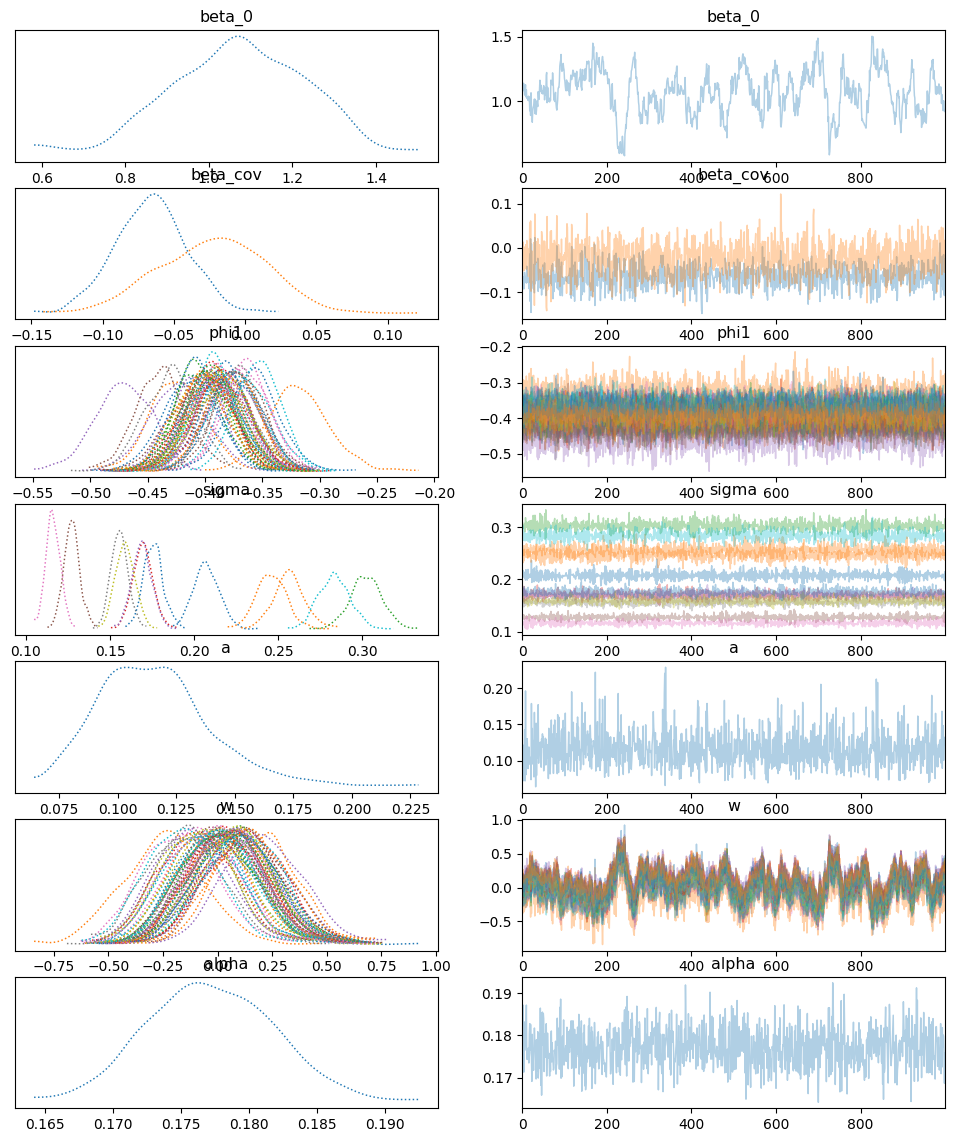

In [62]:
az.plot_trace(arima_az, var_names=["beta_0", "beta_cov", "phi1", "sigma","a", "w", "alpha"], combined= True)
plt.show()

In [63]:
#how many diverging iterations
np.sum(arima_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

In [64]:
clustering = fit.stan_variable(var="cluster_allocs")

In [65]:
clustering

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])

In [66]:
clustering.shape

(1000, 62)

Text(0.5, 1.0, 'Non-null clusters for each iteration')

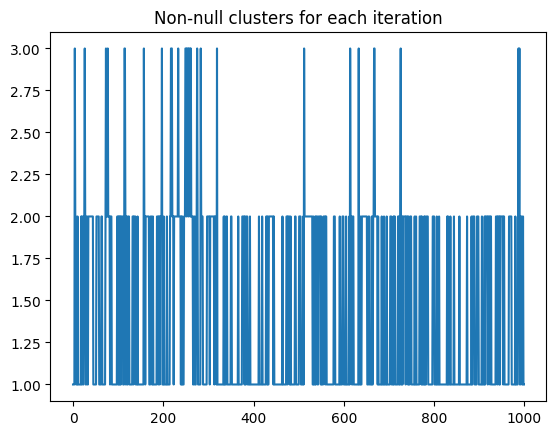

In [67]:
num_cluster_iter = np.zeros(clustering.shape[0])
for i in range(clustering.shape[0]):
    num_cluster_iter[i] = (np.unique(clustering[i,:])).shape[0]
     
plt.plot(num_cluster_iter)
plt.title('Non-null clusters for each iteration')

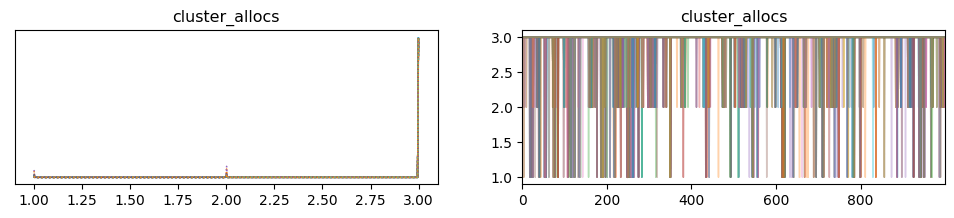

In [68]:
az.plot_trace(arima_az, var_names=["cluster_allocs"], combined= True)
plt.show()

In [69]:
def pi_i_j(clustering):
    #returns P(ci==cj | data)
    pi = np.zeros((clustering.shape[1], clustering.shape[1])) #matrix of dimension (num_staz, num_staz)
    for i in range(clustering.shape[1]):
        for j in range(clustering.shape[1]):
            pi[i, j] = np.mean(clustering[:, i] == clustering[:, j])
    return pi


def binder_loss(clustering, pi_i_j):
    loss = np.zeros(len(clustering)) #for each iter I compute the binder's loss a posteriori 
    for i in range(clustering.shape[1]):
        for j in range(i):
            loss += (np.mean(clustering[:, i] == clustering[:, j]) - pi_i_j[i, j])**2
    #I choose as best iteration the one which minimizes the loss
    best_iter = np.argmin(loss)
    return clustering[best_iter]

In [70]:
pi = pi_i_j(clustering)

In [71]:
best_clus = binder_loss(clustering, pi)
best_clus

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [72]:
best_clus_int = np.asarray(best_clus, dtype = 'int')
best_clus_int

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [73]:
possible_clusters = np.unique (best_clus_int)
possible_clusters
possible_clusters.shape[0] #sum of clusters

1

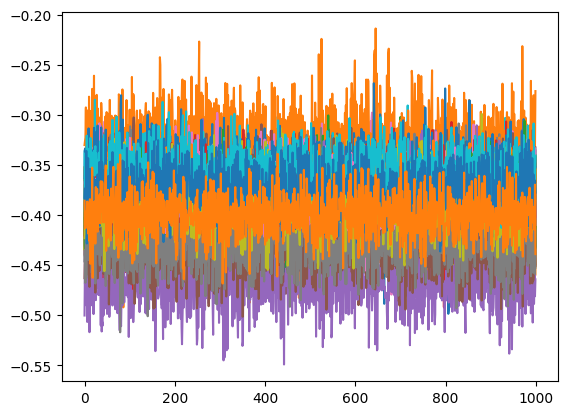

In [74]:
phi1_cluster_chain = fit.stan_variable(var="phi1")
plt.plot(phi1_cluster_chain)
Q1 = np.zeros(62)
Q2 = np.zeros(62)
Q3 = np.zeros(62)
phi2_cluster = []
for i in range(62):
    Q1[i]= np.quantile(phi1_cluster_chain[:,i], 0.025)
    Q2[i]= np.quantile(phi1_cluster_chain[:,i], 0.5)
    Q3[i]= np.quantile(phi1_cluster_chain[:,i], 0.975)
    phi1_cluster.append((phi1_cluster_chain[:,i]).tolist())

#print(Q2)
#print(Q1, Q3)

In [75]:
np.shape(phi1_cluster)

/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(187, 1000)

In [76]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt


def plot_confidence_interval(x, values, cluster, possible_clusters, horizontal_line_width=0.25):
    median = np.quantile(values, 0.5)
    if cluster == possible_clusters[0]:
        color ='r'
    elif cluster ==possible_clusters[1]:
        color ='b'
    elif cluster ==possible_clusters[2]:
        color ='g'
    elif cluster ==possible_clusters[3]:
        color ='k'
    elif cluster ==possible_clusters[4]:
        color ='c'
    else:
        color = 'y'
    left = x - horizontal_line_width / 2
    bottom = np.quantile(values, 0.025)
    right = x + horizontal_line_width / 2
    top = np.quantile(values, 0.975)
    
    confidence_interval = [bottom, top]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, median, 'o', color = color)

    return median, confidence_interval


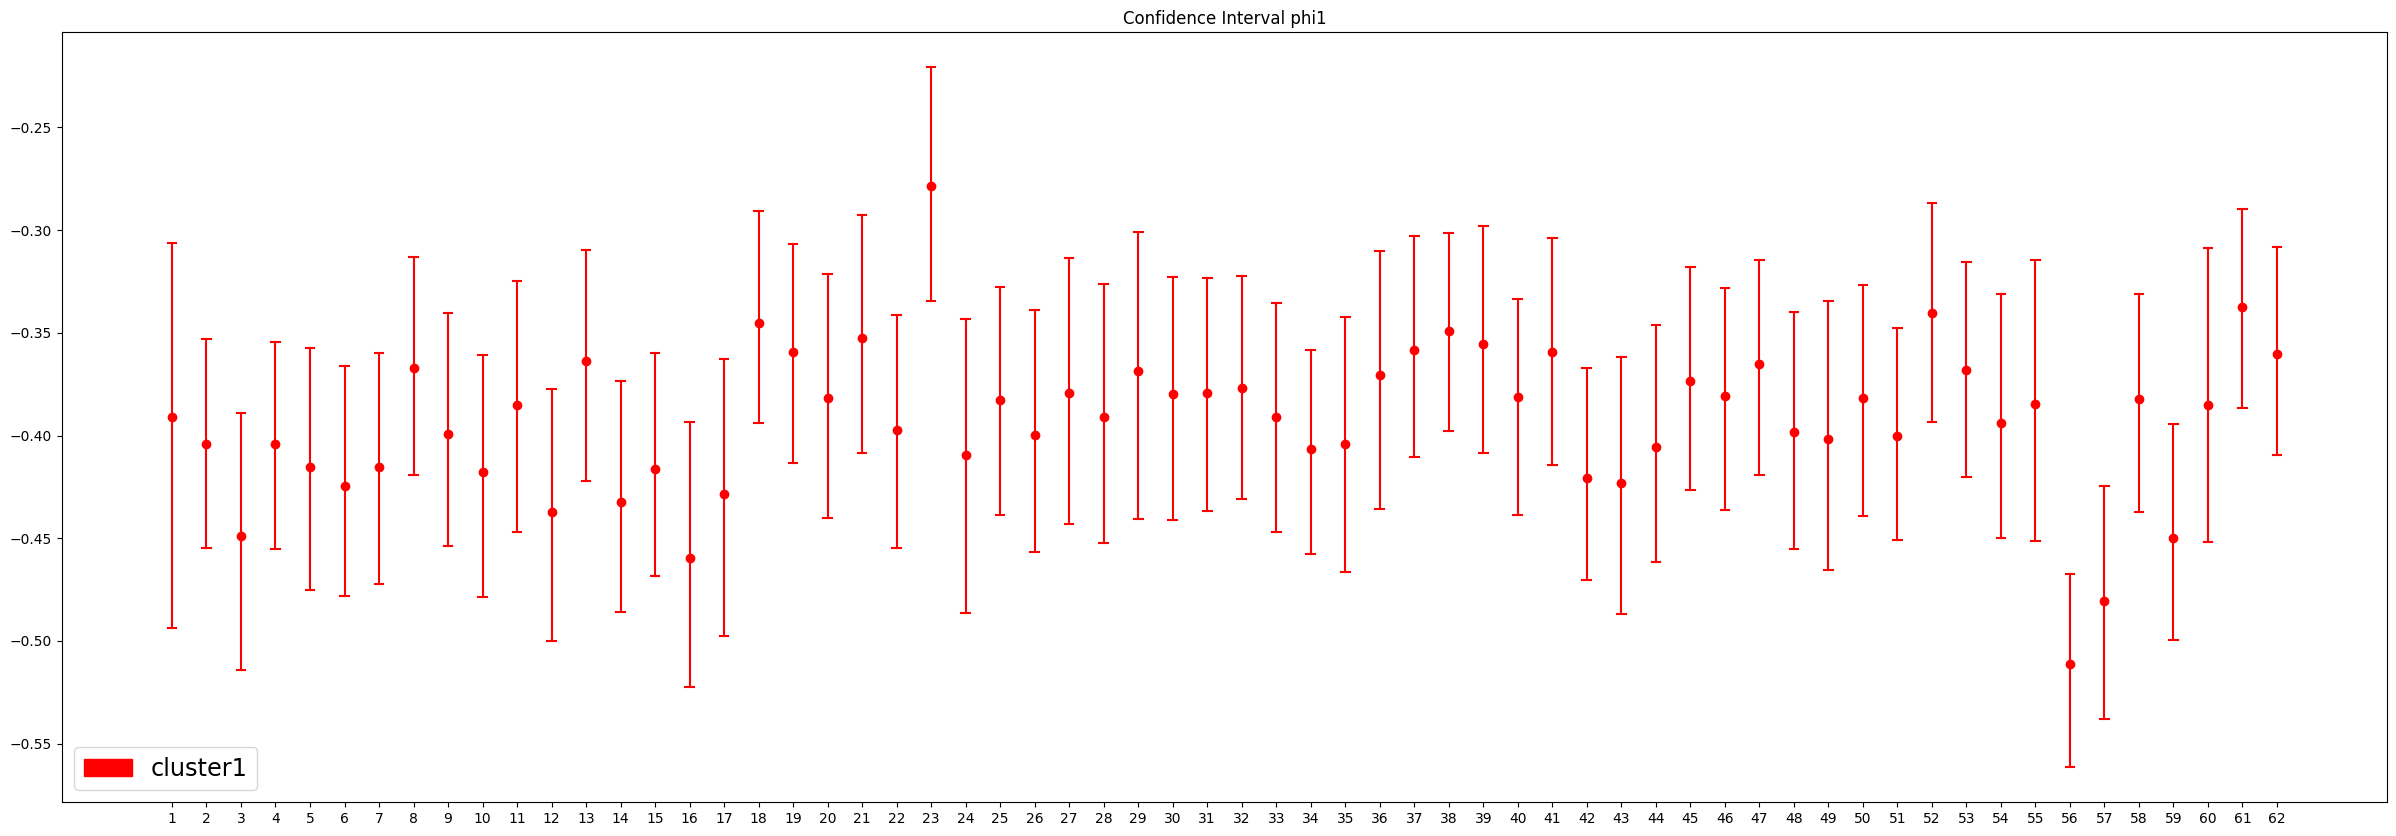

In [77]:
import matplotlib.patches as mpatches
plt.figure(figsize=(30, 10))
plt.xticks(np.arange(62)+1)
plt.title('Confidence Interval phi1')
#plt.axhline(y=0, color= 'black', linestyle = '--')
for i in range(62):
 plot_confidence_interval(i+1, phi1_cluster[i][:], best_clus_int[i], possible_clusters)
red_patch = mpatches.Patch(color='red', label='cluster1')
#blue_patch = mpatches.Patch(color='blue', label='cluster2')
#green_patch = mpatches.Patch(color='green', label='cluster3')
#black_patch = mpatches.Patch(color='black', label='cluster4')
plt.legend(handles=[red_patch], loc = 'lower left', fontsize = 'xx-large')
plt.show()

In [ ]:
#to save the model 
import pickle
pickle.dump(fit_clustering, open('arima_model_varmensile_phibeta.p', 'wb'))

In [ ]:
#to import the model
modello = pickle.load(open('arima_newmodel_var100.p', 'rb'))